___
# Ciência dos Dados - Projeto 3: Filmes#
___

### _Gabriela Caruso e Mariana Abrantes - 2C_ ###
___

## Objetivo ##

Desenvolver um programa que cria uma playlist de filmes similares a um outro usado como parâmetro.


## Imports ##

In [1]:
%matplotlib inline
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy
import seaborn as sb
import sklearn
import sklearn.metrics as sm

from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from pylab import rcParams

np.random.seed(42)

## Lendo as tabelas

In [2]:
#df = pd.read_csv('https://query.data.world/s/dgju3rv2knocz2ost6qyly7vwyekcv')
#writer = pd.ExcelWriter('Projeto3_CD.xlsx')
#df.to_excel(writer,'data')
#writer.save()

In [3]:
df = pd.read_excel('Projeto3_CD.xlsx')
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


## Eliminando colunas

O dataset escolhido vinham com 16 colunas, nas quais nem todas eram importantes para a criação da playlist. As colunas que foram deletadas foram: audio/linguagem, link do filme, tamanho da tela, poster do facebook, palavras-chaves, numero de criticas, numero de reviews e likes do facebook dos atores e diretores. Elas não nos traziam informações relevantes para a agrupação, portanto foram deletadas.

In [4]:
dado = df.drop(labels=None, axis=0, index=None, columns='movie_imdb_link', level=None, inplace=False, errors='raise')
dado2 = dado.drop(labels=None, axis=0, index=None, columns='aspect_ratio', level=None, inplace=False, errors='raise')
dado3 = dado2.drop(labels=None, axis=0, index=None, columns='language', level=None, inplace=False, errors='raise')
dado4 = dado3.drop(labels=None, axis=0, index=None, columns='facenumber_in_poster', level=None, inplace=False, errors='raise')
dado5 = dado4.drop(labels=None, axis=0, index=None, columns='plot_keywords', level=None, inplace=False, errors='raise')
dado6 = dado5.drop(labels=None, axis=0, index=None, columns='num_voted_users', level=None, inplace=False, errors='raise')
dado7 = dado6.drop(labels=None, axis=0, index=None, columns='num_critic_for_reviews', level=None, inplace=False, errors='raise')
dado8 = dado7.drop(labels=None, axis=0, index=None, columns='num_user_for_reviews', level=None, inplace=False, errors='raise')
dado9 = dado8.drop(labels=None, axis=0, index=None, columns='director_facebook_likes', level=None, inplace=False, errors='raise')
dado10 = dado9.drop(labels=None, axis=0, index=None, columns='actor_3_facebook_likes', level=None, inplace=False, errors='raise')
dado11 = dado10.drop(labels=None, axis=0, index=None, columns='actor_1_facebook_likes', level=None, inplace=False, errors='raise')
dado12 = dado11.drop(labels=None, axis=0, index=None, columns='actor_2_facebook_likes', level=None, inplace=False, errors='raise')
data = dado12.dropna(axis = 0, how = "any", thresh = None, subset = None, inplace = False)
data.head()

,color,director_name,duration,actor_2_name,gross,genres,actor_1_name,movie_title,cast_total_facebook_likes,actor_3_name,country,content_rating,budget,title_year,imdb_score,movie_facebook_likes
0,Color,James Cameron,178.0,Joel David Moore,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,4834,Wes Studi,USA,PG-13,237000000.0,2009.0,7.9,33000
1,Color,Gore Verbinski,169.0,Orlando Bloom,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,48350,Jack Davenport,USA,PG-13,300000000.0,2007.0,7.1,0
2,Color,Sam Mendes,148.0,Rory Kinnear,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,11700,Stephanie Sigman,UK,PG-13,245000000.0,2015.0,6.8,85000
3,Color,Christopher Nolan,164.0,Christian Bale,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,106759,Joseph Gordon-Levitt,USA,PG-13,250000000.0,2012.0,8.5,164000
5,Color,Andrew Stanton,132.0,Samantha Morton,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,John Carter,1873,Polly Walker,USA,PG-13,263700000.0,2012.0,6.6,24000


## Print das colunas

In [5]:
colunas = list(data)
print(len(colunas))
colunas

16


['color',
 'director_name',
 'duration',
 'actor_2_name',
 'gross',
 'genres',
 'actor_1_name',
 'movie_title',
 'cast_total_facebook_likes',
 'actor_3_name',
 'country',
 'content_rating',
 'budget',
 'title_year',
 'imdb_score',
 'movie_facebook_likes']

## Fazendo a correlação

In [6]:
data.corr()

,duration,gross,cast_total_facebook_likes,budget,title_year,imdb_score,movie_facebook_likes
duration,1.000000,0.252930,0.123148,0.070070,-0.130492,0.366264,0.221966
gross,0.252930,1.000000,0.237917,0.101757,0.049290,0.216346,0.373275
cast_total_facebook_likes,0.123148,0.237917,1.000000,0.029852,0.122454,0.107451,0.205164
budget,0.070070,0.101757,0.029852,1.000000,0.045332,0.030136,0.054351
title_year,-0.130492,0.049290,0.122454,0.045332,1.000000,-0.135839,0.301236
imdb_score,0.366264,0.216346,0.107451,0.030136,-0.135839,1.000000,0.280577
movie_facebook_likes,0.221966,0.373275,0.205164,0.054351,0.301236,0.280577,1.000000


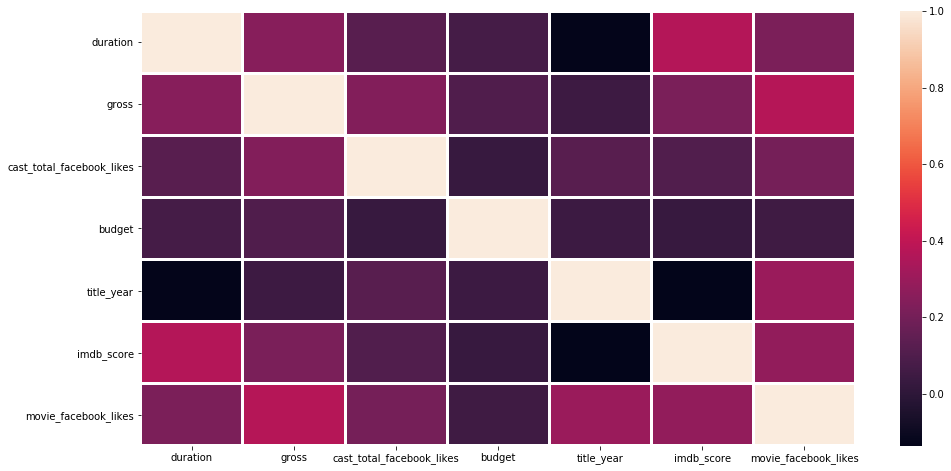

In [7]:
plt.figure(figsize=(16, 8))
sb.heatmap(data.corr(), linewidth=2);

In [8]:
data2 = data[['duration', 'gross', 'cast_total_facebook_likes', 'budget', 'title_year', 'imdb_score', 'movie_facebook_likes']]
data2.head()

,duration,gross,cast_total_facebook_likes,budget,title_year,imdb_score,movie_facebook_likes
0,178.0,760505847.0,4834,237000000.0,2009.0,7.9,33000
1,169.0,309404152.0,48350,300000000.0,2007.0,7.1,0
2,148.0,200074175.0,11700,245000000.0,2015.0,6.8,85000
3,164.0,448130642.0,106759,250000000.0,2012.0,8.5,164000
5,132.0,73058679.0,1873,263700000.0,2012.0,6.6,24000


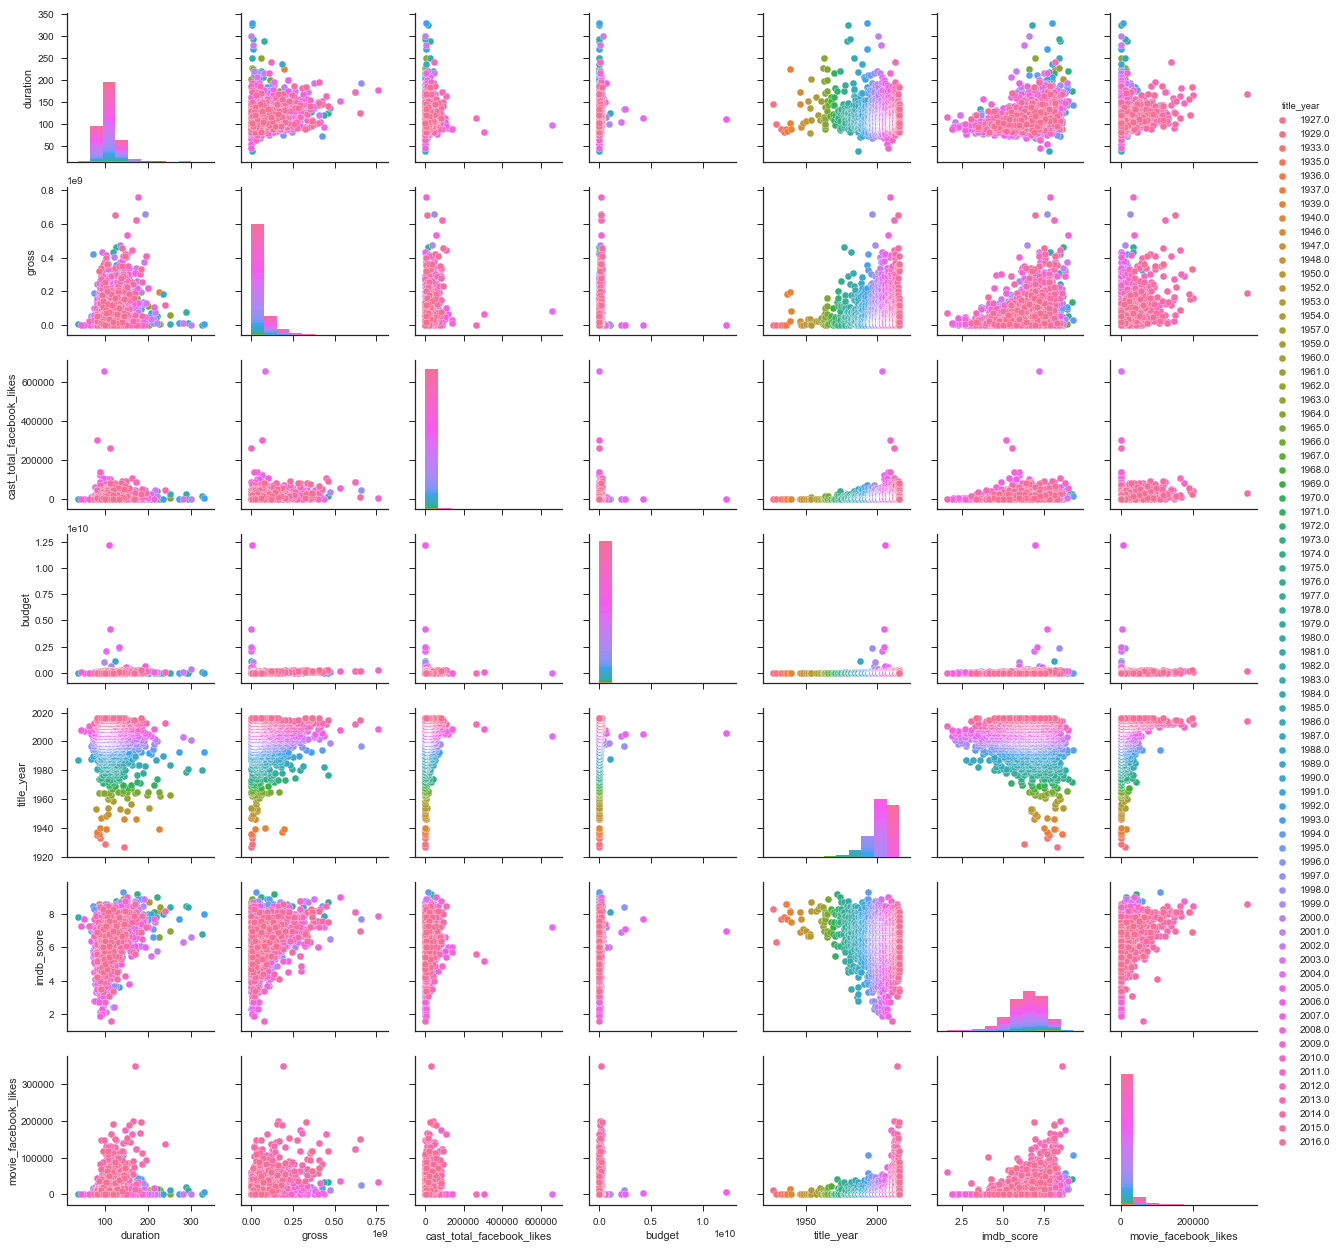

In [9]:
sb.set(style="ticks")
sb.pairplot(data2, hue='title_year');

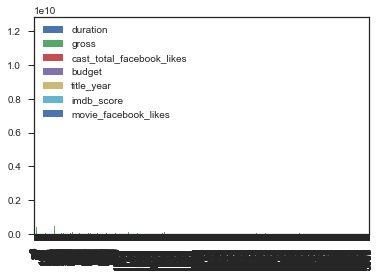

In [10]:
data2.plot.bar()

In [ ]:
#data.plot.scatter(x="title_year", y="movie_facebook_likes", grid=True, color=('purple'));

In [ ]:
#data.plot.scatter(x="imdb_score", y="gross", grid=True, color=('crimson'));

In [ ]:
#data.plot.scatter(x="gross", y="budget", grid=True, color=('purple'));
#print('gross:', data['budget'].corr(data['gross']))

In [ ]:
#data.loc[:,"title_year"].plot.box()
#data['title_year'].describe()

In [ ]:
#data.loc[:,"imdb_score"].plot.box()
#data['imdb_score'].describe()

Para realizar a análise dos dados, calculamos a sua correlação e assim entender quais dados possuiam mais relevância para escolhermos como classificador. (NAO SEI SE PODE FALAR ISSO).Também plotamos uma matriz de todos os dados numéricos para uma melhor visualização. Após plotar a matriz, escolhemos dados que possuiam as maiores correlações ou dados de maior relevância e os análisamos separadamente.

## Alterando os dados escritos por numéricos

In [ ]:
lista_nova = []
for color in data["color"]:
    if color == " Black and White":
        lista_nova.append(1)
    elif color == "Color":
        lista_nova.append(0)
    else:
        lista_nova.append(color)
        
data["color"] = lista_nova
data.head()

In [ ]:
def numerar(dataframe, coluna):
    # Criando a lista de nomes únicos:
    unico = []
    for classe in dataframe[coluna]:
        if classe not in unico:
            unico.append(classe)
            
    # Criando a lista de nomes alterados para números:
    reclassificado = []        
    for item in dataframe[coluna]:
        reclassificado.append(unico.index(item))
    
    # Substituindo a coluna toda do DataFrame:
    dataframe[coluna] = reclassificado
    
    # Retornando o novo DataFrame:
    return dataframe

In [ ]:
numerar(data, "actor_2_name")
numerar(data, "director_name")
numerar(data, "actor_1_name")
numerar(data, "movie_title")
numerar(data, "genres")
numerar(data, "actor_3_name")
numerar(data, "country")
numerar(data, "content_rating")
data.head()

## Clustering

In [ ]:
colunas

In [ ]:
X = data.ix[:, (1,3,5,6,9,13)].values #(0,1,2,3,5,6,9,13)
y = data.ix[:, (0)].values

In [ ]:
Z = linkage(X, "ward")

In [ ]:
f = dendrogram(Z, truncate_mode="lastp", p=20, leaf_rotation=45., leaf_font_size=10., show_contracted=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")

plt.axhline(y=15500)
plt.axhline(y=4000)

plt.show()
print(f.keys())

In [ ]:
f

In [ ]:
k = 3

Hclustering = AgglomerativeClustering(n_clusters=k, affinity="euclidean", linkage="ward")

Hclustering.fit(X)

sm.accuracy_score(y, Hclustering.labels_)

In [ ]:
k = 3

Hclustering = AgglomerativeClustering(n_clusters=k, affinity="euclidean", linkage="complete")

Hclustering.fit(X)

sm.accuracy_score(y, Hclustering.labels_)

In [ ]:
k = 3

Hclustering = AgglomerativeClustering(n_clusters=k, affinity="euclidean", linkage="average")

Hclustering.fit(X)

sm.accuracy_score(y, Hclustering.labels_)

In [ ]:
k = 3

Hclustering = AgglomerativeClustering(n_clusters=k, affinity="manhattan", linkage="complete")

Hclustering.fit(X)

sm.accuracy_score(y, Hclustering.labels_)

In [ ]:
k = 3

Hclustering = AgglomerativeClustering(n_clusters=k, affinity="manhattan", linkage="average")

Hclustering.fit(X)

sm.accuracy_score(y, Hclustering.labels_)

In [ ]:
k = 3

Hclustering = AgglomerativeClustering(n_clusters=k, affinity="cosine", linkage="complete")

Hclustering.fit(X)

sm.accuracy_score(y, Hclustering.labels_)

In [ ]:
k = 3

Hclustering = AgglomerativeClustering(n_clusters=k, affinity="cosine", linkage="average")

Hclustering.fit(X)

sm.accuracy_score(y, Hclustering.labels_)